# Comparing Single-model-per-threshold for AIFS-RainForests
Identical to the `validation` notebook but reworked to compare multiple approaches 

In this document we will inspect some basic performance measures of AIFS and HRES forecasts calibrated with RainForests. The primary measures used are: continous ranked probability score (CRPS), brier score and reliability curves.

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import scores
import flox

test = ["2024_07", "2024_10", "2025_01", "2025_04", "2025_07"]
val = ["2024_06", "2024_09", "2024_12", "2025_03", "2025_06"]
val = test
AIFS_path = "/path/to/model_output/AIFS/calibrated_months/calibrated_precip"
HRES_path = "/path/to/model_output/HRES/calibrated_months/calibrated_precip"

AIFS_multi_path = "/path/to/model_output/multi_param/AIFS/calibrated_months/calibrated_precip"
HRES_multi_path = "/path/to/model_output/multi_param/HRES/calibrated_months/calibrated_precip"

AIFS_combined_path = "/path/to/model_output/combined_param/AIFS/calibrated_months/calibrated_precip"
HRES_combined_path = "/path/to/model_output/combined_param/HRES/calibrated_months/calibrated_precip"

AIFS_combined_lt_path = "/path/to/model_output/combined_lt/AIFS/calibrated_months/calibrated_precip"
HRES_combined_lt_path = "/path/to/model_output/combined_lt/HRES/calibrated_months/calibrated_precip"


paths = {"AIFS": AIFS_path, 
         "HRES": HRES_path, 
         "AIFS_multi": AIFS_multi_path, 
         "HRES_multi":HRES_multi_path, 
         "HRES_combined":HRES_combined_path, 
         "AIFS_combined":AIFS_combined_path, 
         "AIFS_1lt": AIFS_combined_lt_path, 
         "HRES_1lt":HRES_combined_lt_path, }

models = ["AIFS","HRES","AIFS_multi","HRES_multi", "AIFS_combined", "HRES_combined", "AIFS_1lt","HRES_1lt"]

new_AIFS_colour = "#004E89"
old_AIFS_colour = "#8AC6D0"
new_HRES_colour = "#FF6B35"
old_HRES_colour = "#F7C59F"

Load in all months in the validation `val` list. We then want to concatenate them into one big list of forecasts, `combine_by_coords` does this over three dimensions: `site_id`, `forecast_reference_time` and `lead_time`. To join the forecasts with the observations we need to reindex to ensure the index created by `time`, `forecast_period` and `site_id` is unique.

In [2]:
%%capture
vals = {}
for model in models:
    months = []
    for m_y in val:
        monthly = xr.load_dataset(f"{paths[model]}_{m_y}.nc")
        months.append(monthly)
        #print(monthly)
    # some slight differences in meta data between older and new AIFS data
    valset = xr.combine_by_coords(months, combine_attrs="override")
    vals[model] = valset
vals["AIFS"], vals["HRES"] = xr.align(vals["AIFS"], vals["HRES"], join="inner")
vals["AIFS_multi"], vals["HRES_multi"] = xr.align(vals["AIFS_multi"], vals["HRES_multi"], join="inner")
vals["AIFS_combined"], vals["HRES_combined"] = xr.align(vals["AIFS_combined"], vals["HRES_combined"], join="inner")
vals["AIFS_1lt"], vals["HRES_1lt"] = xr.align(vals["AIFS_1lt"], vals["HRES_1lt"], join="inner")

In [3]:
vals_da = {}
for model, ds in vals.items():
    vals_da[model] = ds[
        "probability_of_lwe_thickness_of_precipitation_amount_above_threshold"
    ]
    vals_da[model] = (
        vals_da[model].groupby(["time", "forecast_period", "site_id"]).first()
    )

In [4]:
# filter so we only compare where both models are not NaN
vals_da["AIFS"] = vals_da["AIFS"].where(~xr.ufuncs.isnan(vals_da["HRES"]))
vals_da["HRES"] = vals_da["HRES"].where(~xr.ufuncs.isnan(vals_da["AIFS"]))

vals_da["AIFS_multi"] = vals_da["AIFS_multi"].where(~xr.ufuncs.isnan(vals_da["HRES_multi"]))
vals_da["HRES_multi"] = vals_da["HRES_multi"].where(~xr.ufuncs.isnan(vals_da["AIFS_multi"]))

vals_da["AIFS_combined"] = vals_da["AIFS_combined"].where(~xr.ufuncs.isnan(vals_da["HRES_combined"]))
vals_da["HRES_combined"] = vals_da["HRES_combined"].where(~xr.ufuncs.isnan(vals_da["AIFS_combined"]))

vals_da["AIFS_1lt"] = vals_da["AIFS_1lt"].where(~xr.ufuncs.isnan(vals_da["HRES_1lt"]))
vals_da["HRES_1lt"] = vals_da["HRES_1lt"].where(~xr.ufuncs.isnan(vals_da["AIFS_1lt"]))

In [5]:
# sanity check, we want AIFS and HRES to be forecasting 100% probability of at least 0mm of rainfall
np.nanmin(vals_da["AIFS_1lt"].sel(threshold=0).values); np.nanmin(vals_da["HRES_1lt"].sel(threshold=0).values)

np.float32(1.0)

In [ ]:
obs_path = "/path/to/obs/precipitation_accumulation-PT24H.parquet"
obs = pd.read_parquet(obs_path).reset_index()
# format for xarray so it works with scores library
obs["time"] = pd.to_datetime(obs["time"], errors="raise").astype("datetime64[ns]")
obs.rename(columns={"spot_index": "site_id"}, inplace=True)
obs = obs.set_index(["time", "site_id"])
obs.head()
obs["lwe_thickness_of_precipitation_amount"][:5]

time                 site_id
2024-03-02 12:00:00  1006       0.0244
2024-03-03 12:00:00  1006       0.0394
2024-03-04 12:00:00  1006       0.0080
2024-03-05 12:00:00  1006       0.0328
2024-03-06 12:00:00  1006       0.0250
Name: lwe_thickness_of_precipitation_amount, dtype: float64

In [7]:
RECORD_RAINFALL = 0.96

obs_x = obs.to_xarray()
obs_da = obs_x["lwe_thickness_of_precipitation_amount"]
obs_da = obs_da.where(obs_da < RECORD_RAINFALL, obs_da, np.nan)
obs_da.head()

<xarray.DataArray 'lwe_thickness_of_precipitation_amount' (time: 5, site_id: 5)> Size: 200B
array([[0.0244    ,        nan,        nan,        nan, 0.0018    ],
       [0.0394    , 0.        , 0.00061379, 0.        , 0.0002    ],
       [0.008     , 0.        , 0.        , 0.0028    , 0.0066    ],
       [0.0328    , 0.        , 0.0034    , 0.024     , 0.0402    ],
       [0.025     , 0.        , 0.0044    , 0.0004    , 0.0068    ]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-03-02T12:00:00 ... 2024-03-06T12:...
  * site_id  (site_id) int64 40B 1006 1007 1019 1020 2056

## Begin validation
Now we have a dataArray of all our calibrated forecasts in the validation set and the corresponding observed values. With this dataArray we can apply metrics from the scores library. The headline metric is the CRPS because it captures how the forecast performs accross the all probabilities in the artificial CDF.

In [8]:
from scores.probability import crps_cdf, brier_score, isotonic_fit
import matplotlib.pyplot as plt

In [9]:
%%capture
crps_res = {}
for model in models:
    pred_subset = vals_da[model]
    common_times = np.intersect1d(pred_subset.time.values, obs_da.time.values)
    pred_filtered = 1 - pred_subset.sel(time=common_times)
    obs_filtered = obs_da.sel(time=common_times)
    crps_res[model] = crps_cdf(
        pred_filtered,
        obs_filtered,
        threshold_dim="threshold",
        preserve_dims=["forecast_period"],
    )

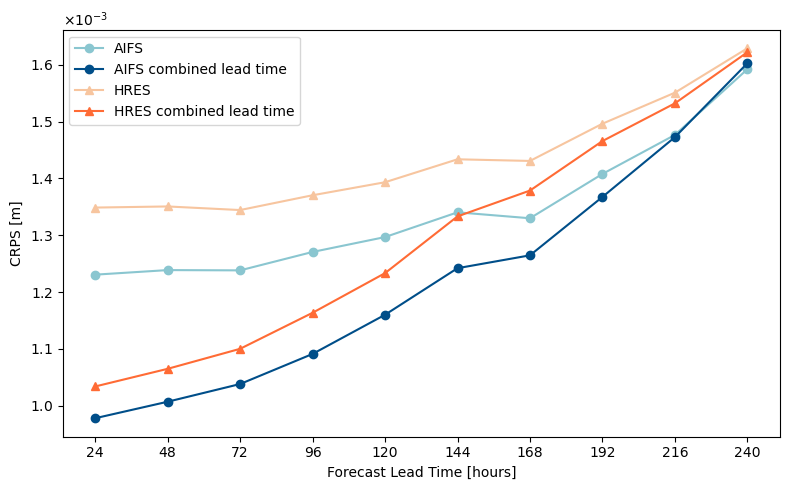

In [10]:
from matplotlib.ticker import ScalarFormatter
hours = np.arange(24, 240 + 24, 24)

series1 = crps_res["AIFS"]["total"]
series2 = crps_res["HRES"]["total"]
series3 = crps_res["AIFS_multi"]["total"]
series4 = crps_res["HRES_multi"]["total"]
series5 = crps_res["AIFS_combined"]["total"]
series6 = crps_res["HRES_combined"]["total"]
series7 = crps_res["AIFS_1lt"]["total"]
series8 = crps_res["HRES_1lt"]["total"]

plt.figure(figsize=(8, 5))

# --- choosing which plots to include ----

plt.plot(hours, series1, marker="o", label="AIFS", color=old_AIFS_colour)
#plt.plot(hours, series3, marker="o", label="AIFS multi params")
#plt.plot(hours, series5, marker="o", label="AIFS combined params")
plt.plot(hours, series7, marker="o", label="AIFS combined lead time", color=new_AIFS_colour)
#plt.plot(hours, series9, marker="o", label="AIFS combined lead time - new param")
plt.plot(hours, series2, marker="^", label="HRES", color=old_HRES_colour)
#plt.plot(hours, series4, marker="^", label="HRES multi params")
#plt.plot(hours, series6, marker="^", label="HRES combined params")
plt.plot(hours, series8, marker="^", label="HRES combined lead time", color=new_HRES_colour)
#plt.plot(hours, series10, marker="^", label="HRES combined lead time - new param")


plt.xlabel("Forecast Lead Time [hours]")
plt.ylabel("CRPS [m]")
#plt.title("CRPS across lead-times")

plt.gca().yaxis.set_major_formatter(
    ScalarFormatter(useMathText=True)
)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3, -3))


# Use scientific notation for small values
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.xticks(hours)
plt.legend()
plt.tight_layout()
plt.savefig("CRPS_test_set_comparing_approaches.png", dpi=300)
plt.show()

In [11]:
# thresholds
THRESHOLDS = [
    0.0,
    0.00001,
    0.00005,
    0.0001,
    0.0002,
    0.0004,
    0.0006,
    0.001,
    0.002,
    0.005,
    0.007,
    0.01,
    0.015,
    0.025,
    0.035,
    0.05,
    0.075,
    0.1,
    0.125,
    0.15,
    0.2,
    0.25,
    0.3,
    0.35,
    0.4,
    0.45,
    0.5,
]

### Reliability Diagrams
Using both isotonic fit and binned methods

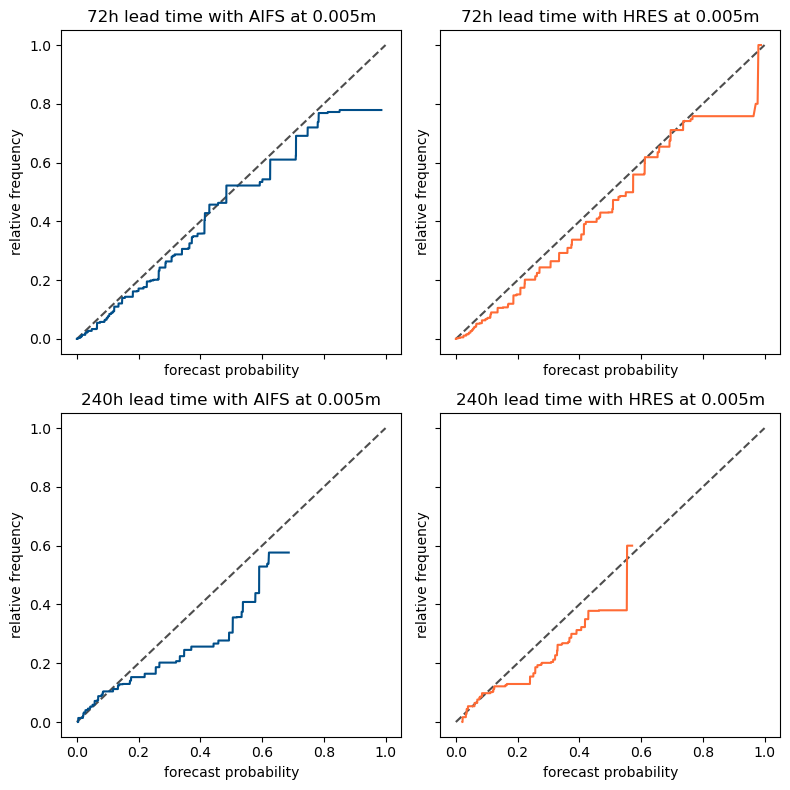

In [ ]:
threshold = THRESHOLDS[9]


lead_times = [3,3,10,10]
models = ["AIFS_1lt","HRES_1lt","AIFS_1lt","HRES_1lt"]
model_names = ["AIFS", "HRES", "AIFS", "HRES"]
colours = [new_AIFS_colour, new_HRES_colour, new_AIFS_colour, new_HRES_colour]

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)


for ax, model, lt, name, colour in zip(axs.ravel(), models, lead_times, model_names, colours):
    pred_subset = vals_da[model].sel(
        threshold=threshold, forecast_period=pd.to_timedelta(lt, unit="D")
    )
    common_times = np.intersect1d(pred_subset.time.values, obs_da.time.values)
    pred_filtered = pred_subset.sel(time=common_times)
    obs_filtered = obs_da.sel(time=common_times)
    
    pred_filtered
    obs_filtered = (obs_filtered >= threshold).astype(int)
    obs_filtered
    
    iso_fit_result = isotonic_fit(fcst=pred_filtered, obs=obs_filtered, functional="mean")
    iso_fit_result

    #print(iso_fit_result["fcst_sorted"])

    
    ax.plot([0, 1], [0, 1], ls="--", c=".3")
    ax.plot(
        iso_fit_result["fcst_sorted"], iso_fit_result["regression_values"], color=colour
    )
    ax.set_xlabel("forecast probability")
    ax.set_ylabel("relative frequency")
    ax.set_title(f"{lt*24}h lead time with {name} at {threshold}m")


#plt.title(f"Reliability diagram at {threshold}m threshold with {model}")
plt.tight_layout()
plt.savefig('lead_time_reliability_chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
from flox.xarray import xarray_reduce
def reliability(fc, obs, prob_bins):
    variable = list(fc.keys())[0]
    threshold_list = fc["threshold"].values
    threshold_obs = obs >= xr.DataArray(
        threshold_list,
        dims=["threshold"],
        coords={"threshold": ("threshold", threshold_list)},
    )
    fc_obs = xr.merge(
        [fc.rename({variable: "fc"}), threshold_obs.rename({variable: "obs"})]
    )
    fc_obs.load()
    print(fc_obs)
    rel_fc_obs = xarray_reduce(
        fc_obs,
        "fc",
        dim=["site_id", "time"],
        func="mean",
        expected_groups=pd.IntervalIndex.from_breaks(prob_bins, closed="left"),
        fill_value=np.nan,
    )
    rel_count = xarray_reduce(
        fc,
        variable,
        dim=["site_id", "time"],
        func="count",
        expected_groups=pd.IntervalIndex.from_breaks(prob_bins, closed="left"),
        fill_value=0,
    )
    rel_fc_obs.load()
    rel_count.load()
    return rel_fc_obs, rel_count


In [15]:
models = ["AIFS","HRES"]
rel_fc_obs_dic = {}
rel_count_dic = {}
for model in models:
    pred_subset = vals_da[model].sel(forecast_period=pd.to_timedelta(1, unit="D"))
    common_times = np.intersect1d(pred_subset.time.values, obs_da.time.values)
    pred_filtered = pred_subset.sel(time=common_times)
    obs_filtered = obs_da.sel(time=common_times)
    rel_fc_obs, rel_count = reliability(
        pred_filtered.to_dataset(), 
        obs_filtered.to_dataset().rename({"lwe_thickness_of_precipitation_amount":'probability_of_lwe_thickness_of_precipitation_amount_above_threshold'}),
        np.arange(0,1.1,0.1))
    rel_fc_obs_dic[model] = rel_fc_obs
    rel_count_dic[model] = rel_count


<xarray.Dataset> Size: 19MB
Dimensions:          (threshold: 27, time: 176, site_id: 780)
Coordinates:
  * threshold        (threshold) float32 108B 0.0 1e-05 5e-05 ... 0.4 0.45 0.5
  * time             (time) datetime64[ns] 1kB 2024-07-02T12:00:00 ... 2025-0...
  * site_id          (site_id) int64 6kB 1006 1007 1019 ... 515010 541150 541157
    forecast_period  timedelta64[ns] 8B 1 days
Data variables:
    fc               (threshold, time, site_id) float32 15MB 1.0 1.0 ... nan nan
    obs              (time, site_id, threshold) bool 4MB True False ... False
<xarray.Dataset> Size: 19MB
Dimensions:          (threshold: 27, time: 176, site_id: 780)
Coordinates:
  * threshold        (threshold) float32 108B 0.0 1e-05 5e-05 ... 0.4 0.45 0.5
  * time             (time) datetime64[ns] 1kB 2024-07-02T12:00:00 ... 2025-0...
  * site_id          (site_id) int64 6kB 1006 1007 1019 ... 515010 541150 541157
    forecast_period  timedelta64[ns] 8B 1 days
Data variables:
    fc               (thres

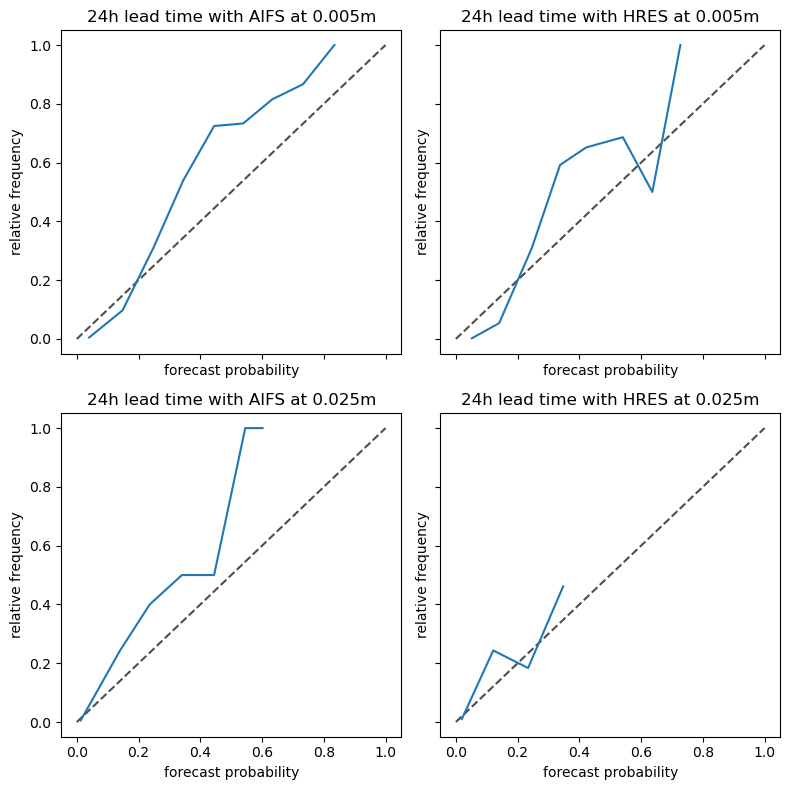

In [16]:
threshold = THRESHOLDS[9]


thresholds = [THRESHOLDS[9],THRESHOLDS[9],THRESHOLDS[13],THRESHOLDS[13]]
models = ["AIFS","HRES","AIFS","HRES"]

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)


for ax, model, threshold in zip(axs.ravel(), models, thresholds):
    ax.plot([0, 1], [0, 1], ls="--", c=".3")
    ax.plot(
        rel_fc_obs_dic[model]["fc"].sel(threshold=threshold).values,
        rel_fc_obs_dic[model]["obs"].sel(threshold=threshold).values,
    )
    ax.set_xlabel("forecast probability")
    ax.set_ylabel("relative frequency")
    ax.set_title(f"24h lead time with {model} at {threshold}m")


#plt.title(f"Reliability diagram at {threshold}m threshold with {model}")
plt.tight_layout()
plt.savefig('reliability_chart.png', dpi=300, bbox_inches='tight')
plt.show()


### Inspecting overall model confidence

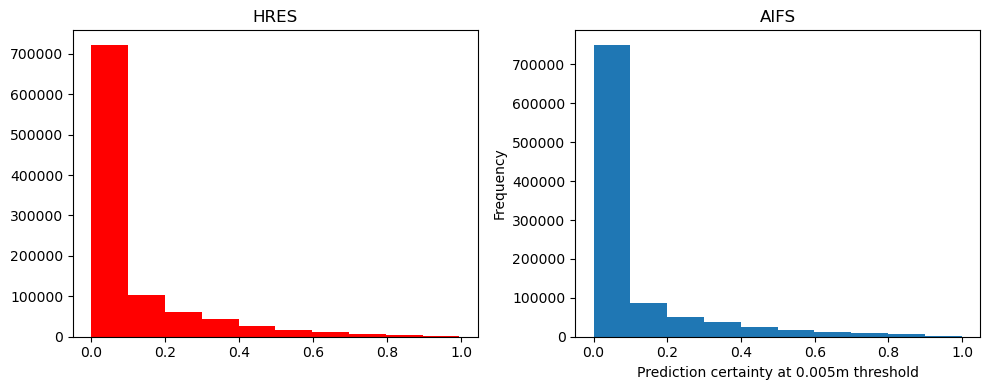

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
eg_hres = vals_da["HRES_1lt"].sel(threshold=0.005).values.flatten()
eg_aifs = vals_da["AIFS_1lt"].sel(threshold=0.005).values.flatten()
axes[0].hist(eg_hres, bins=10, label="HRES", color="red")
axes[1].hist(eg_aifs, bins=10, label="AIFS")
axes[0].set_title("HRES")
axes[1].set_title("AIFS")
plt.xlabel("Prediction certainty at 0.005m threshold")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Calculate Brier scores

In [20]:
brier_results = pd.DataFrame({"threshold": THRESHOLDS})
#brier_results["AIFS"] = np.nan
#brier_results["HRES"] = np.nan
for lead_time in range(1,11):
    for model in ["AIFS", "HRES", "HRES_multi","AIFS_multi","AIFS_1lt","HRES_1lt"]:
        for i, threshold in enumerate(THRESHOLDS):
            # print(threshold,i)
            pred_subset = vals_da[model].sel(
                threshold=threshold, forecast_period=pd.to_timedelta(lead_time, unit="D")
            )
            common_times = np.intersect1d(pred_subset.time.values, obs_da.time.values)
            pred_filtered = pred_subset.sel(time=common_times)
            obs_filtered = obs_da.sel(time=common_times)
    
            pred_filtered
            obs_filtered = xr.where(
                obs_filtered.isnull(), np.nan, (obs_filtered >= threshold).astype(int)
            )
            obs_filtered
            # for each rainfall threshold, report the minimum and maximum confidence (probability)
            #print(
            #    f"for threshold {threshold:f}m --- min:{np.nanmin(pred_filtered.values):04f} max:{np.nanmax(pred_filtered.values):04f}, {obs_filtered.values.mean()}"
            #)
    
            brier = brier_score(pred_filtered, obs_filtered)
            # print(brier.item())
            brier_results.loc[i, f"{model} {lead_time} days"] = brier.item()
brier_results.to_csv("/home/572/fe2804/jupyter_testing/brier_results_combined.csv")

In [27]:
brier_results.iloc[:,0:7]

,threshold,AIFS 1 days,HRES 1 days,HRES_multi 1 days,AIFS_multi 1 days,AIFS_1lt 1 days,HRES_1lt 1 days
0,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.00001,1.456271e-01,1.482059e-01,1.496122e-01,1.465407e-01,1.273936e-01,1.265979e-01
2,0.00005,1.456271e-01,1.482059e-01,1.496122e-01,1.465407e-01,1.273936e-01,1.265979e-01
3,0.00010,1.456271e-01,1.482059e-01,1.496122e-01,1.465407e-01,1.273936e-01,1.265979e-01
4,0.00020,1.342514e-01,1.399886e-01,1.409604e-01,1.348356e-01,1.134717e-01,1.147949e-01
5,0.00040,1.067504e-01,1.170839e-01,1.182046e-01,1.075965e-01,8.192405e-02,8.545944e-02
6,0.00060,9.931736e-02,1.103787e-01,1.112836e-01,9.996616e-02,7.416904e-02,7.824927e-02
7,0.00100,9.261402e-02,1.031551e-01,1.036981e-01,9.282379e-02,6.861211e-02,7.251390e-02
8,0.00200,8.025394e-02,8.930045e-02,9.010841e-02,8.067426e-02,5.899136e-02,6.279663e-02
9,0.00500,5.884637e-02,6.611361e-02,6.668640e-02,5.912996e-02,4.422262e-02,4.686071e-02
